source https://www.youtube.com/watch?v=QIUxPv5PJOY&t=9s

### This notebook uses a Long Short Term Memory (LSTM) neural network to predict the adjusted closing stock price using the previous 60 days stock price

In [25]:
# Import the dependencies

import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df = pd.read_csv("Resources/stocks_joined.csv")
df

company_id                   company    date_ipo market_capitalization  \
0            1.0               Chewy, Inc,  2019-06-14                13.95B   
1            1.0               Chewy, Inc,  2019-06-14                13.95B   
2            1.0               Chewy, Inc,  2019-06-14                13.95B   
3            1.0               Chewy, Inc,  2019-06-14                13.95B   
4            1.0               Chewy, Inc,  2019-06-14                13.95B   
...          ...                       ...         ...                   ...   
4199         4.0  IDEXX Laboratories, Inc.  1991-06-21               27.574B   
4200         4.0  IDEXX Laboratories, Inc.  1991-06-21               27.574B   
4201         4.0  IDEXX Laboratories, Inc.  1991-06-21               27.574B   
4202         4.0  IDEXX Laboratories, Inc.  1991-06-21               27.574B   
4203         4.0  IDEXX Laboratories, Inc.  1991-06-21               27.574B   

            pet_market_segment  company_size                 Date   Adj_Close  \
0     Pet Supplies, E-commerce       21300.0  2019-06-17 00:00:00   33.700001   
1     Pet Supplies, E-commerce       21300.0  2019-06-18 00:00:00   37.360001   
2     Pet Supplies, E-commerce       21300.0  2019-06-19 00:00:00   34.900002   
3     Pet Supplies, E-commerce       21300.0  2019-06-20 00:00:00   34.230000   
4     Pet Supplies, E-commerce       21300.0  2019-06-21 00:00:00   32.279999   
...                        ...           ...                  ...         ...   
4199                Healthcare       10000.0  2021-10-11 00:00:00  612.770020   
4200                Healthcare       10000.0  2021-10-12 00:00:00  615.909973   
4201                Healthcare       10000.0  2021-10-13 00:00:00  623.119995   
4202                Healthcare       10000.0  2021-10-14 00:00:00  629.719971   
4203                Healthcare       10000.0  2021-10-15 00:00:00  635.150024   

        Volume Ticker  
0     15403000   CHWY  
1     11022800   CHWY  
2     11163600   CHWY  
3      7901000   CHWY  
4      9277700   CHWY  
...        ...    ...  
4199    182100   IDXX  
4200    287400   IDXX  
4201    255200   IDXX  
4202    456300   IDXX  
4203    262000   IDXX  

[4204 rows x 10 columns]

In [2]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns = {'Adj Close':'Adj_Close'}, inplace=True)
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4204 entries, 2019-06-17 to 2021-10-15
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company_id             2689 non-null   float64
 1   company                2689 non-null   object 
 2   date_ipo               2689 non-null   object 
 3   market_capitalization  2689 non-null   object 
 4   pet_market_segment     2689 non-null   object 
 5   company_size           2689 non-null   float64
 6   Adj_Close              4204 non-null   float64
 7   Volume                 4204 non-null   int64  
 8   Ticker                 4204 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 328.4+ KB


Ticker
CHWY    AxesSubplot(0.125,0.2;0.775x0.68)
ELAN    AxesSubplot(0.125,0.2;0.775x0.68)
FRPT    AxesSubplot(0.125,0.2;0.775x0.68)
IDXX    AxesSubplot(0.125,0.2;0.775x0.68)
PETQ    AxesSubplot(0.125,0.2;0.775x0.68)
TRUP    AxesSubplot(0.125,0.2;0.775x0.68)
TSCO    AxesSubplot(0.125,0.2;0.775x0.68)
ZTS     AxesSubplot(0.125,0.2;0.775x0.68)
Name: Adj_Close, dtype: object

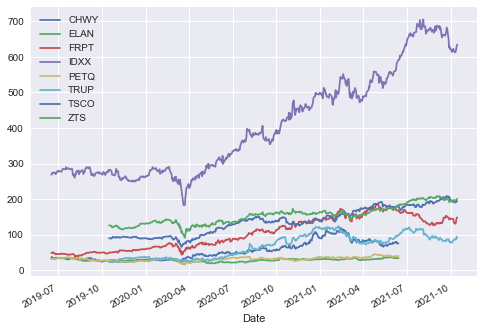

In [5]:
#df = df[df.Ticker != "IDXX"]
df.groupby('Ticker')['Adj_Close'].plot(legend=True)

In [6]:
chwy_df = df[df.Ticker == 'CHWY']

In [7]:
chwy_df.shape

(503, 9)

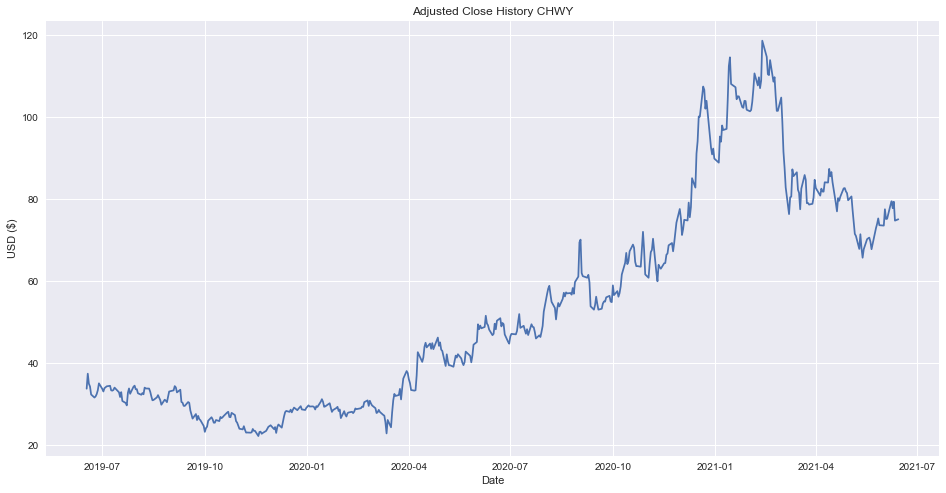

In [8]:
plt.figure(figsize=(16,8))
plt.title('Adjusted Close History CHWY')
plt.plot(chwy_df.Adj_Close)
plt.xlabel('Date')
plt.ylabel('USD ($)')
plt.show()

In [9]:
# separate the target (Adj_Close) into a new df
data = chwy_df.filter(['Adj_Close'])

# convert df to a numpy array
chwy_data = data.values

# get the number of rows to train the model on using 80% of the data
training_data_len = math.ceil(len(chwy_data) * .8)
training_data_len

403

In [10]:
# scale the data between 0 and 1 inclusive
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(chwy_data)
scaled_data

array([[0.11982189],
       [0.15772578],
       [0.13224941],
       [0.12531069],
       [0.10511599],
       [0.09734882],
       [0.10014498],
       [0.10604805],
       [0.11578295],
       [0.13328501],
       [0.11930409],
       [0.11267604],
       [0.12106463],
       [0.12572494],
       [0.12707128],
       [0.11557582],
       [0.1147473 ],
       [0.11650789],
       [0.12251449],
       [0.11350456],
       [0.11060482],
       [0.09869512],
       [0.11101904],
       [0.08864956],
       [0.08367854],
       [0.07746481],
       [0.10946563],
       [0.12033969],
       [0.10687657],
       [0.12458576],
       [0.12738195],
       [0.11837201],
       [0.11857915],
       [0.10811931],
       [0.10439105],
       [0.10863711],
       [0.10563383],
       [0.12241095],
       [0.12033969],
       [0.12002901],
       [0.11226182],
       [0.10055925],
       [0.09041013],
       [0.09123863],
       [0.09776306],
       [0.10345899],
       [0.09703812],
       [0.090

In [11]:
# create the training set
train_data = scaled_data[0:training_data_len, :]

# split the data into x_train and y_train sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
    # gets 60 values from 0 to 59
    x_train.append(train_data[i-60:i, 0])
    # gets the 61st value
    y_train.append(train_data[i, 0])
    if i<= 60:
        print(x_train) # contains the past 60 values
        print(y_train) # contains the next value which we want to predict

[array([0.11982189, 0.15772578, 0.13224941, 0.12531069, 0.10511599,
       0.09734882, 0.10014498, 0.10604805, 0.11578295, 0.13328501,
       0.11930409, 0.11267604, 0.12106463, 0.12572494, 0.12707128,
       0.11557582, 0.1147473 , 0.11650789, 0.12251449, 0.11350456,
       0.11060482, 0.09869512, 0.11101904, 0.08864956, 0.08367854,
       0.07746481, 0.10946563, 0.12033969, 0.10687657, 0.12458576,
       0.12738195, 0.11837201, 0.11857915, 0.10811931, 0.10439105,
       0.10863711, 0.10563383, 0.12241095, 0.12033969, 0.12002901,
       0.11226182, 0.10055925, 0.09041013, 0.09123863, 0.09776306,
       0.10345899, 0.09703812, 0.09092793, 0.07922537, 0.09185999,
       0.08947805, 0.08564624, 0.09910938, 0.1125725 , 0.11557582,
       0.12624276, 0.12292876, 0.1103977 , 0.11712924, 0.0860605 ])]
[0.0844034977919377]


In [12]:
# convert the training sets to numpy arrays for the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape  # has 2 dimensions

(343, 60)

In [13]:
# reshape the x_train data to meet the LSTM model requirements for #samples, #timesteps and #features (3 dimensions)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(343, 60, 1)

In [26]:
# build the LSTM model
model = keras.Sequential()

# add layer with 50 neurons, and first layer needs input_shape equal to # of timesteps
model.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(50, return_sequences=False)) # no more LSTM layers to follow
model.add(layers.Dense(25)) 
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
# compile the model
model.compile(optimizer='adam', loss= 'mean_squared_error') # loss measures how well the model trained

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
343/343 [==============================] - 8s 16ms/step - loss: 0.0061
Epoch 2/5
343/343 [==============================] - 5s 16ms/step - loss: 0.0025
Epoch 3/5
343/343 [==============================] - 6s 16ms/step - loss: 0.0027
Epoch 4/5
343/343 [==============================] - 6s 16ms/step - loss: 0.0022
Epoch 5/5
343/343 [==============================] - 5s 16ms/step - loss: 0.0019


In [28]:
# create the testing data sets
# create a new array containing scaled values using the remaining 20%
test_data = scaled_data[training_data_len - 60: , : ]

x_test = []
y_test = chwy_data[training_data_len:] # actual adj_close values, not scaled

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [29]:
# convert to np array
x_test = np.array(x_test)

In [30]:
# reshape from a 2D to 3D array for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
# get the model's adj_close predictions
predictions = model.predict(x_test)

# inverse transform the predictions to restore the scaled values to compare with actual prices
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 12ms/step


In [32]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse  # rsme closer to 0 shows better accuracy

0.6455504156640626

C:\Users\laura\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


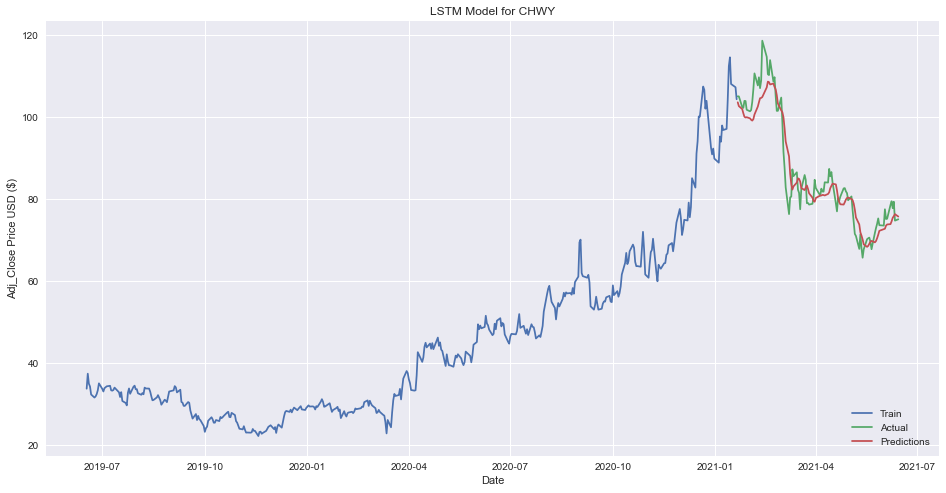

In [33]:
# plot
data = chwy_df.filter(['Adj_Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model for CHWY')
plt.xlabel('Date')
plt.ylabel('Adj_Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj_Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [34]:
# show the actual and predicted prices
validation

Adj_Close  Predictions
Date                               
2021-01-21  105.099998   103.633453
2021-01-22  105.080002   102.705009
2021-01-25  102.489998   101.994980
2021-01-26  102.290001   100.969048
2021-01-27  103.989998   100.112053
...                ...          ...
2021-06-08   79.470001    74.557281
2021-06-09   77.769997    75.442795
2021-06-10   79.349998    75.837944
2021-06-11   74.739998    76.319679
2021-06-14   75.070000    75.737846

[100 rows x 2 columns]

In [35]:
# show the historical data
data

Adj_Close
Date                 
2019-06-17  33.700001
2019-06-18  37.360001
2019-06-19  34.900002
2019-06-20  34.230000
2019-06-21  32.279999
...               ...
2021-06-08  79.470001
2021-06-09  77.769997
2021-06-10  79.349998
2021-06-11  74.739998
2021-06-14  75.070000

[503 rows x 1 columns]